In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils import data
import matplotlib.pyplot as plt

In [2]:
train_data = torchvision.datasets.FashionMNIST(root='data',
                                               train=True,
                                               download=True,
                                               transform=ToTensor(),
                                               target_transform=None)

test_data = torchvision.datasets.FashionMNIST(root='data',
                                               train=False,
                                               download=True,
                                               transform=ToTensor(),
                                               target_transform=None)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
data_classes = train_data.classes
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [4]:
len(train_data)

60000

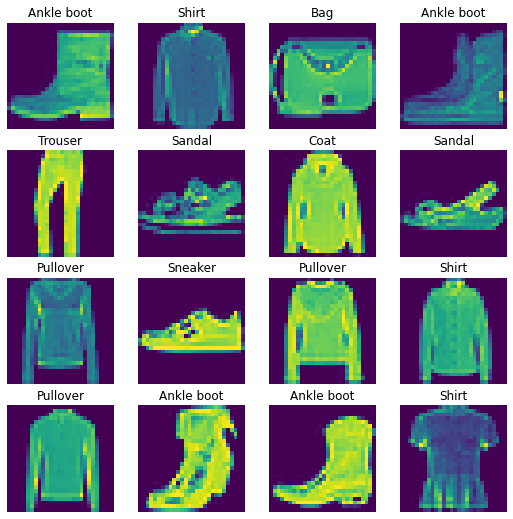

In [5]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  idx = torch.randint(0, len(train_data), size=(1,)).item()
  img, label = train_data[idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze())
  plt.title(data_classes[label])
  plt.axis(False)

In [6]:
train_batch = data.DataLoader(train_data, 32, True)
test_batch = data.DataLoader(test_data, 32, True)

len(train_batch)

1875

In [8]:
class FashionMnistCNN(nn.Module):
  def __init__(self, in_channel:int, out_feature:int, hidden_layer=32):
    super().__init__()
    self.CnnLayer1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=hidden_layer, kernel_size=3, padding='same', stride=1),
        nn.BatchNorm2d(num_features=hidden_layer),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.CnnLayer2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_layer, out_channels=hidden_layer, kernel_size=3, padding='same', stride=1),
        nn.BatchNorm2d(num_features=hidden_layer),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.FcLayer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_layer*7*7, out_features=hidden_layer),
        nn.ReLU(),
        nn.Linear(in_features=hidden_layer, out_features=out_feature),

    )

  def forward(self, x: torch.tensor) -> torch.tensor:
    output = self.CnnLayer1(x)
    # print(output.shape)
    output = self.CnnLayer2(output)
    # print(output.shape)
    output = self.FcLayer(output)

    return output

model = FashionMnistCNN(1, 10, 10)

loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

def accuracy_fn(true, pred):
  correct = torch.eq(true, pred)
  return (torch.sum(correct)/len(true))*100

In [ ]:
from time import time

start = time()

for epoch in range(1, 4):
  print(f'Epoch: {epoch}\n-------')
  train_loss = 0
  train_acc = 0
  for batch, (X, y) in enumerate(train_batch):
    model.train()

    y_logit = model(X)

    loss = loss_fn(y_logit, y)
    train_loss += loss

    accuracy = accuracy_fn(y, y_logit.argmax(dim=1))
    train_acc += accuracy

    opt.zero_grad()
    loss.backward()
    opt.step()
    if batch % 400 == 0 and batch != 0:
      print(f' batch: {batch} -- {batch*32} of {len(train_batch.dataset)} sample')
      
  train_loss /= len(train_batch)
  train_acc /= len(train_batch)
  print(f'\nTrain loss: {train_loss} -- Train accuracy: {train_acc}\n')

  model.eval()
  with torch.inference_mode():
    test_loss = 0
    test_acc = 0
    for X_test, y_test in test_batch:
      y_test_logit = model(X_test)

      test_loss += loss_fn(y_test_logit, y_test)
      test_acc += accuracy_fn(y_test, y_test_logit.argmax(dim=1))
    
    test_loss /= len(test_batch)
    test_acc /= len(test_batch)
    print(f'Test loss: {test_loss} -- Test accuracy: {test_acc}\n')
    print(f'Time: {time() - start:.3f} seconds\n')
  

Epoch: 1
-------
 batch: 400 -- 12800 of 60000 sample
 batch: 800 -- 25600 of 60000 sample
 batch: 1200 -- 38400 of 60000 sample
 batch: 1600 -- 51200 of 60000 sample

Train loss: 0.46849915385246277 -- Train accuracy: 83.0999984741211

Test loss: 0.39533114433288574 -- Test accuracy: 86.16213989257812

Time: 33.287 seconds

Epoch: 2
-------
 batch: 400 -- 12800 of 60000 sample
 batch: 800 -- 25600 of 60000 sample
 batch: 1200 -- 38400 of 60000 sample
 batch: 1600 -- 51200 of 60000 sample

Train loss: 0.351669043302536 -- Train accuracy: 87.26333618164062

Test loss: 0.35990363359451294 -- Test accuracy: 87.29033660888672

Time: 66.737 seconds

Epoch: 3
-------
 batch: 400 -- 12800 of 60000 sample
 batch: 800 -- 25600 of 60000 sample
 batch: 1200 -- 38400 of 60000 sample
 batch: 1600 -- 51200 of 60000 sample

Train loss: 0.32491758465766907 -- Train accuracy: 88.33000183105469

Test loss: 0.3569803237915039 -- Test accuracy: 87.63977813720703

Time: 98.580 seconds



In [ ]:
first_data = {'test_loss' : round((test_loss).item(), 4),
              'test_accuracy' : round(test_acc.item(), 2),
              'train_loss' : round(train_loss.item(), 4),
              'train_accuracy' : round(train_acc.item(), 2)}
first_data

{'test_loss': 0.361,
 'test_accuracy': 86.8,
 'train_loss': 0.3461,
 'train_accuracy': 87.68}

In [ ]:
second_data = {'test_loss' : round((test_loss).item(), 4),
              'test_accuracy' : round(test_acc.item(), 2),
              'train_loss' : round(train_loss.item(), 4),
              'train_accuracy' : round(train_acc.item(), 2)}
second_data

{'test_loss': 0.361,
 'test_accuracy': 86.8,
 'train_loss': 0.3461,
 'train_accuracy': 87.68}

In [ ]:
a = torch.tensor([[1, 2, 3, 4],[4, 5, 6, 7]])
b = torch.tensor([[1, 2, 3, 4],[1, 5, 6, 7]])
c = torch.tensor([[1, 2, 3, 4],[2, 5, 6, 7]])
d = torch.cat([a, b, c], 1)

In [ ]:
d.shape

torch.Size([2, 12])

In [ ]:
a.view(a.size(0), -1)

tensor([[1, 2, 3, 4],
        [4, 5, 6, 7]])

In [ ]:
d.size(0)

2

In [ ]:
class FashionMnistCNN(nn.Module):
  def __init__(self, in_channel:int, out_feature:int, hidden_layer=32):
    super().__init__()
    self.CnnLayer1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=hidden_layer, kernel_size=3, padding='same', stride=1),
        nn.BatchNorm2d(num_features=hidden_layer),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.CnnLayer2 = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=hidden_layer, kernel_size=3, padding='same', stride=1),
        nn.BatchNorm2d(num_features=hidden_layer),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.FcLayer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=2*hidden_layer*14*14, out_features=hidden_layer),
        nn.ReLU(),
        nn.Linear(in_features=hidden_layer, out_features=out_feature),

    )

  def forward(self, x: torch.tensor) -> torch.tensor:
    output1 = self.CnnLayer1(x)
    output2 = self.CnnLayer2(x)
    # print(output1.shape)
    # print(output2.shape)
    output = torch.cat([output1, output2], 1)
    # print(output.shape)

    output = self.FcLayer(output)

    return output

model = FashionMnistCNN(1, 10, 10)

loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

def accuracy_fn(true, pred):
  correct = torch.eq(true, pred)
  return (torch.sum(correct)/len(true))*100

In [ ]:
dummy = torch.rand((1, 1, 28, 28))
inception = FashionMnistCNN(1, 10, 10)
inception(dummy)

tensor([[ 0.0511,  0.0420,  0.2229,  0.3493,  0.1273, -0.0413, -0.3379,  0.1093,
         -0.1706, -0.2701]], grad_fn=<AddmmBackward0>)

In [ ]:
from time import time

start = time()

for epoch in range(1, 4):
  print(f'Epoch: {epoch}\n-------')
  train_loss = 0
  train_acc = 0
  for batch, (X, y) in enumerate(train_batch):
    inception.train()

    y_logit = inception(X)

    loss = loss_fn(y_logit, y)
    train_loss += loss

    accuracy = accuracy_fn(y, y_logit.argmax(dim=1))
    train_acc += accuracy

    opt.zero_grad()
    loss.backward()
    opt.step()
    if batch % 400 == 0 and batch != 0:
      print(f' batch: {batch} -- {batch*32} of {len(train_batch.dataset)} sample')
      
  train_loss /= len(train_batch)
  train_acc /= len(train_batch)
  print(f'\nTrain loss: {train_loss} -- Train accuracy: {train_acc}\n')

  inception.eval()
  with torch.inference_mode():
    test_loss = 0
    test_acc = 0
    for X_test, y_test in test_batch:
      y_test_logit = inception(X_test)

      test_loss += loss_fn(y_test_logit, y_test)
      test_acc += accuracy_fn(y_test, y_test_logit.argmax(dim=1))
    
    test_loss /= len(test_batch)
    test_acc /= len(test_batch)
    print(f'Test loss: {test_loss} -- Test accuracy: {test_acc}\n')
    print(f'Time: {time() - start:.3f} seconds\n')

Epoch: 1
-------
 batch: 400 -- 12800 of 60000 sample
 batch: 800 -- 25600 of 60000 sample
 batch: 1200 -- 38400 of 60000 sample
 batch: 1600 -- 51200 of 60000 sample

Train loss: 2.3798346519470215 -- Train accuracy: 9.619999885559082

Test loss: 2.3803539276123047 -- Test accuracy: 9.514776229858398

Time: 37.944 seconds

Epoch: 2
-------
 batch: 400 -- 12800 of 60000 sample
 batch: 800 -- 25600 of 60000 sample
 batch: 1200 -- 38400 of 60000 sample
 batch: 1600 -- 51200 of 60000 sample

Train loss: 2.3798227310180664 -- Train accuracy: 9.633333206176758

Test loss: 2.3800251483917236 -- Test accuracy: 9.554712295532227

Time: 75.876 seconds

Epoch: 3
-------
 batch: 400 -- 12800 of 60000 sample
 batch: 800 -- 25600 of 60000 sample
 batch: 1200 -- 38400 of 60000 sample
 batch: 1600 -- 51200 of 60000 sample

Train loss: 2.3798258304595947 -- Train accuracy: 9.65333366394043

Test loss: 2.378981351852417 -- Test accuracy: 9.524760246276855

Time: 113.426 seconds

